In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# Exploration
ipl_train = pd.read_csv('IPL_train.csv')
train_data = pd.DataFrame(ipl_train)

In [30]:
matches = train_data.groupby(train_data.match_id)

In [114]:
class Batsman:
    def __init__(self, match, name):
        self.match = match.copy()
        self.name = name
        self.stats = self.match.groupby(self.match.batsman).get_group(self.name)
        self.scorechart = self.stats.batsman_runs
        self.balls_played = self.stats.shape[0]
        self.finalSR = np.sum(self.scorechart)*100/self.balls_played
        self.isDismissed = self.stats.player_dismissed.isnull().values.all()
    def calcInstSR(self, over, ball):
        score = 0
        sr = 0
        balls = 0
        for index, row in self.stats.iterrows():
            if row['over'] == over and row['ball'] == ball:
                return sr
            score += row['batsman_runs']
            balls += 1
            sr = score*100/balls

In [115]:
class Bowler:
    def __init__(self, match, name):
        self.match = match.copy()
        self.name = name
        self.stats = self.match.groupby(self.match.bowler).get_group(self.name)
        self.runschart = self.stats.total_runs
        self.balls_played = self.stats.shape[0]
        self.finalEco = np.sum(self.runschart)*6/self.balls_played
    def calcInstEco(self, over, ball):
        score = 0
        eco = 0
        balls = 0
        for index, row in self.stats.iterrows():
            if row['over'] == over and row['ball'] == ball:
                return eco
            score += row['total_runs']
            if row['wide_runs'] == 0 or row['noball_runs'] == 0:
                balls += 1
            eco = score*6/balls

In [116]:
class Match:
    def __init__(self, match):
        self.match = match.copy()
        self.match_id = self.match.match_id.unique()[0]
        self.match.fillna(0, inplace=True)
        self.batsmen = dict([(i, Batsman(self.match, i)) for i in self.match.batsman.unique()])
        self.bowlers = dict([(i, Bowler(self.match, i)) for i in self.match.bowler.unique()])
    def display_stats(self):
        display(self.match)
    def createCRRcol(self):
        match_copy = self.match.copy()
        score = 0
        balls_played = 0
        runrate = [0]
        for i in range(self.match.index[0]+1, self.match.index[-1]+1):
            score += match_copy.total_runs[i-1]
            if match_copy.wide_runs[i] == 0 or match_copy.noball_runs[i] == 0:
                balls_played += 1
            crr = score*6/balls_played
            runrate.append(crr)
        self.match['CRR'] = runrate
    def createSRCol(self):
        match_copy = self.match.copy()
        srcol = []
        for index, row in match_copy.iterrows():
            inst_sr = self.batsmen[row['batsman']].calcInstSR(row['over'], row['ball'])
            srcol.append(inst_sr)
        self.match['SR'] = srcol
    def createEcoCol(self):
        match_copy = self.match.copy()
        ecocol = []
        for index, row in match_copy.iterrows():
            inst_eco = self.bowlers[row['bowler']].calcInstEco(row['over'], row['ball'])
            ecocol.append(inst_eco)
        self.match['Economy'] = ecocol
    def createExpExtra(self):
        match_copy = self.match.copy()
        extracol = [0]
        extras = 0
        balls_played = 0
        for i in range(self.match.index[0]+1, self.match.index[-1]+1):
            extras += match_copy.extra_runs[i-1]
            if match_copy.extra_runs[i] != 0:
                balls_played += 1
            if balls_played != 0:
                expextra = extras/balls_played
            else:
                expextra = 0
            extracol.append(expextra)
        self.match['ExpExtra'] = extracol
    def createWicketsLeftCol(self):
        match_copy = self.match.copy()
        wickets = 10
        w_left = [10]
        for i in range(self.match.index[0]+1, self.match.index[-1]+1):
            if match_copy.player_dismissed[i] != 0:
                wickets -= 1
            w_left.append(wickets)
        self.match['WicketsLeft'] = w_left
    def createScoreCol(self):
        match_copy = self.match.copy()
        scorecol = []
        score = 0
        for i in range(self.match.index[0], self.match.index[-1]+1):
            score += match_copy.total_runs[i]
            scorecol.append(score)
        self.match['Score'] = scorecol

In [380]:
def compressMatch(match):
    match_obj = Match(match)
    match_obj.createCRRcol()
    avgRR = np.mean(match_obj.match.CRR)
    avgSR = np.mean(np.array([i.finalSR for i in match_obj.batsmen.values()]))
    Score1 = np.max(np.array([np.sum(i.scorechart) for i in match_obj.batsmen.values()]))            
    avgEco = np.mean(np.array([i.finalEco for i in match_obj.bowlers.values()]))
    match_obj.createExpExtra()
    avgExtra = match_obj.match.ExpExtra.tail(1).item()
    match_obj.createWicketsLeftCol()
    finalWickets = np.min(match_obj.match.WicketsLeft)
    match_id = match_obj.match_id
    match_obj.createScoreCol()
    score = np.max(match_obj.match.Score)
    BowlConf = 1/(1+np.exp(finalWickets))
    return [match_id, avgRR, avgSR/100, Score1/100, avgEco, avgExtra, score/10]

In [400]:
def createX(matches):
    rows = []
    for match_id, match in matches:
        row = compressMatch(match)
        rows.append(row)
    col_names = ['match_id', 'avgRR', 'SRscaled', 'Score1scaled', 'Ecoscaled', 'Extras', 'Scorescaled']
    df = pd.DataFrame(rows, columns=col_names)
    return df

In [401]:
df = createX(matches)

(300, 7)

In [383]:
Y_data = df['Scorescaled']
df.drop(['match_id', 'Scorescaled'], axis=1, inplace=True)
X_data = df

In [396]:
from sklearn.model_selection import train_test_split
f = 0.12

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=f, random_state=0)

In [397]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=False)

lr.fit(X_train, Y_train)

LinearRegression(fit_intercept=False)

In [398]:
Y_pred = lr.predict(X_test)

from sklearn.metrics import mean_squared_error as mse

# print(mse(Y_pred*10, Y_test*10))

41.61400542802872


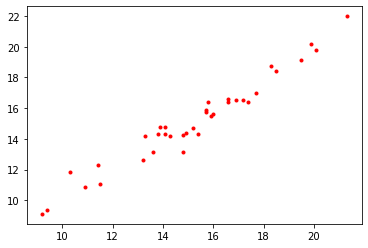

In [399]:
# plt.plot(Y_test, Y_pred, 'r.')
# plt.show()

In [404]:
ipl_test = pd.read_csv('IPL_test.csv')
test_data = pd.DataFrame(ipl_test)

In [405]:
test_matches = test_data.groupby(test_data.match_id)

In [409]:
test_df = createX(test_matches)

In [410]:
test_df.drop(['match_id'], axis=1, inplace=True)
x_data = test_df

In [416]:
x_data.drop(['Scorescaled'], axis=1, inplace=True)

In [417]:
test_pred = lr.predict(x_data)

In [420]:
final_predictions = test_pred*10

In [422]:
final_df = pd.DataFrame(final_predictions, columns=['predictions'])

,predictions
0,134.614041
1,139.099116
2,143.659038
3,175.518675
4,183.661056
...,...
95,150.437851
96,118.044043
97,157.780558
98,146.609016


In [423]:
final_df.to_csv('IPL_test_predictions.csv')